<a href="https://colab.research.google.com/github/ipeirotis-org/datasets/blob/main/Restaurant_Inspections/DOH_Restaurant_Inspections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www1.nyc.gov/site/doh/business/food-operators/the-inspection-process.page

See https://www1.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf

In [ ]:
!pip install -q google-cloud-secret-manager

from google.colab import auth
auth.authenticate_user()

from google.cloud import secretmanager

def access_secret_version(project_id, secret_id, version_id):
    """
    Access the payload of the given secret version and return it.

    Args:
        project_id (str): Google Cloud project ID.
        secret_id (str): ID of the secret to access.
        version_id (str): ID of the version to access.
    Returns:
        str: The secret version's payload, or None if
        the version does not exist.
    """
    client = secretmanager.SecretManagerServiceClient()
    name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"
    response = client.access_secret_version(request={"name": name})
    return response.payload.data.decode("UTF-8")


mysql_pass = access_secret_version("nyu-datasets", "MYSQL_PASSWORD", "latest")

## Download Latest Dataset

In [ ]:
!curl 'https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD' -o restaurants.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  134M    0  134M    0     0  2631k      0 --:--:--  0:00:52 --:--:-- 3488k


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("restaurants.csv", dtype = 'object')

In [ ]:
initial_size = len(df)
initial_size

290500

In [ ]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
df.dtypes

,0
CAMIS,object
DBA,object
BORO,object
BUILDING,object
STREET,object
ZIPCODE,object
PHONE,object
CUISINE DESCRIPTION,object
INSPECTION DATE,object
ACTION,object


In [ ]:
# Adding underscores in all column names
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_').upper())
df.columns = cols

In [ ]:
df.dtypes

,0
CAMIS,object
DBA,object
BORO,object
BUILDING,object
STREET,object
ZIPCODE,object
PHONE,object
CUISINE_DESCRIPTION,object
INSPECTION_DATE,object
ACTION,object


In [ ]:
df.drop('LOCATION', axis=1, inplace=True)

## Cleaning Individual Columns

In [ ]:
df.CAMIS.isnull().sum()

np.int64(0)

In [ ]:
df.DBA.isnull().sum()

np.int64(5)

In [ ]:
# Checks that all CAMIS values correpond to a unique DBA value
# ie the same CAMIS always has the same DBA
max_cardinality = df[['DBA','CAMIS']].pivot_table(
    index='CAMIS',
    values='DBA',
    aggfunc=pd.Series.nunique
).DBA.max()

assert(max_cardinality==1)

### INSPECTION_TYPE

In [ ]:
df.INSPECTION_TYPE.value_counts()

,count
INSPECTION_TYPE,
Cycle Inspection / Initial Inspection,152797
Cycle Inspection / Re-inspection,60040
Pre-permit (Operational) / Initial Inspection,38129
Pre-permit (Operational) / Re-inspection,10839
Administrative Miscellaneous / Initial Inspection,8419
Pre-permit (Non-operational) / Initial Inspection,3729
Cycle Inspection / Reopening Inspection,2760
Pre-permit (Operational) / Compliance Inspection,2088
Administrative Miscellaneous / Re-inspection,1825


In [ ]:
sum(df.INSPECTION_TYPE.isnull())

3874

In [ ]:
# We create a column "TO_DELETE" to mark the entries that we are not interested in.
# We will perform first the inspection/analysis on all the attributes, and then delete the rows

# Drop all cases where inspection is NULL
df['TO_DELETE'] = df.INSPECTION_TYPE.isnull()

In [ ]:
sum(df['TO_DELETE'])

3874

In [ ]:
# Break INSPECTION_TYPE into two columns, and also delete some inspection types

# Create a new column that contains the results of the split on the '/'' character
lst = df.INSPECTION_TYPE.str.split(' / ').values.tolist()
lst = [ l if type(l)==type(list()) else ['',''] for l in lst ]
t = pd.DataFrame(lst)


In [ ]:
t[0].value_counts()

,count
0,
Cycle Inspection,216970
Pre-permit (Operational),52112
Administrative Miscellaneous,10494
Pre-permit (Non-operational),4214
,3874
Inter-Agency Task Force,948
Smoke-Free Air Act,728
Trans Fat,552
Calorie Posting,500


In [ ]:
t[1].value_counts()

,count
1,
Initial Inspection,205645
Re-inspection,73364
,3874
Reopening Inspection,3644
Compliance Inspection,3610
Second Compliance Inspection,360
Limited Inspection,3


In [ ]:
# Keep only cycle inspections. Ignore admin, pre-permit, transfat, and calorie posting inspections
# We will only keep the initial inspections and the re-inspections. The other types are border cases

keep = df.INSPECTION_TYPE.isin( ['Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection'])


In [ ]:
# Check how many we will drop: ~keep means negation on the keep and summing up adds up the 'True'
sum(~keep)

77663

In [ ]:
# Adding the "not keep" entries into the TO_DELETE

# The |= operator is a shortcut for df['TO_DELETE'] = df['TO_DELETE'] | ~keep
# We use the bit-OR operator (|), as we want to keep the existing deletions, and add the ones from the
# additional condition
df['TO_DELETE'] |= ~keep

In [ ]:
# Rename the two entries that we will keep into simpler values

df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Initial Inspection',
    value = 'Initial Inspection',
    inplace=True
)
df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Re-inspection',
    value = 'Re-inspection',
    inplace=True
)

/tmp/ipython-input-1122464254.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["INSPECTION_TYPE"].replace(
/tmp/ipython-input-1122464254.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({co

In [ ]:
sum(df['TO_DELETE'])

77663

### BORO

In [ ]:
df.BORO.value_counts()

,count
BORO,
Manhattan,107446
Brooklyn,74825
Queens,71426
Bronx,26726
Staten Island,10057
0,20


In [ ]:
sum(df.BORO.isnull())

0

In [ ]:
# Replace the "Missing" in BORO with null
# df.BORO = df.BORO.replace('Missing', np.NaN)

In [ ]:
missing = set(df[df.BORO.isnull()].CAMIS)
# missing

In [ ]:
sum(df.BORO == '0')

20

In [ ]:
# Remove the entries with null/missing BORO value
# Not worth trying to fix.
df['TO_DELETE'] |= (df.BORO == '0')

In [ ]:
sum(df['TO_DELETE'])

77663

### BUILDING

In [ ]:
sum(df.BUILDING.isnull())

557

In [ ]:
# Inspect the entries with missing street number
# df[df.BUILDING.isnull()]

In [ ]:
# Dropping the violations listed without street number
# Most are in train stations and in airports, but there
# are a few others in 'regular' locations

df['TO_DELETE'] |= df.BUILDING.isnull()

In [ ]:
sum(df['TO_DELETE'])

78107

### STREET

In [ ]:
# Check that no street values are empty
sum(df.STREET.isnull())

9

In [ ]:
df['TO_DELETE'] |= df.STREET.isnull()

In [ ]:
sum(df['TO_DELETE'])

78107

### ZIPCODE

In [ ]:
sum(df.ZIPCODE.isnull())

2991

In [ ]:
len(set(df[df.ZIPCODE.isnull()].CAMIS))

434

In [ ]:
df['TO_DELETE'] |= df.ZIPCODE.isnull()

In [ ]:
# TODO: Fill in the missing zip codes, perhaps with geocoding of the addresses
# For now, we just drop the cases without ZIPCODE

### CUISINE DESCRIPTION

In [ ]:
df.CUISINE_DESCRIPTION.value_counts()

,count
CUISINE_DESCRIPTION,
American,45242
Chinese,28195
Coffee/Tea,20212
Pizza,17388
Latin American,13231
...,...
Nuts/Confectionary,35
Czech,15
Polynesian,6


In [ ]:
len(df.CUISINE_DESCRIPTION.value_counts())

90

In [ ]:
sum(df.CUISINE_DESCRIPTION.isnull())

3874

In [ ]:
'''
df.CUISINE_DESCRIPTION.replace(
    to_replace='Café/Coffee/Tea',
    value = 'Cafe',
    inplace=True
)

df.CUISINE_DESCRIPTION.replace(
    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
    value = 'Latin',
    inplace=True
)
'''

"\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Café/Coffee/Tea',\n    value = 'Cafe',\n    inplace=True\n)\n\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',\n    value = 'Latin',\n    inplace=True\n)\n"

### INSPECTION_DATE

In [ ]:
df["INSPECTION_DATE"] = pd.to_datetime(df["INSPECTION_DATE"], format="%m/%d/%Y")

In [ ]:
df.INSPECTION_DATE.describe()

,INSPECTION_DATE
count,290500
mean,2022-06-02 06:37:44.839931648
min,1900-01-01 00:00:00
25%,2023-02-27 00:00:00
50%,2024-03-27 00:00:00
75%,2025-01-10 00:00:00
max,2025-10-19 00:00:00


In [ ]:
sum(df.INSPECTION_DATE.isnull())

0

<Axes: >

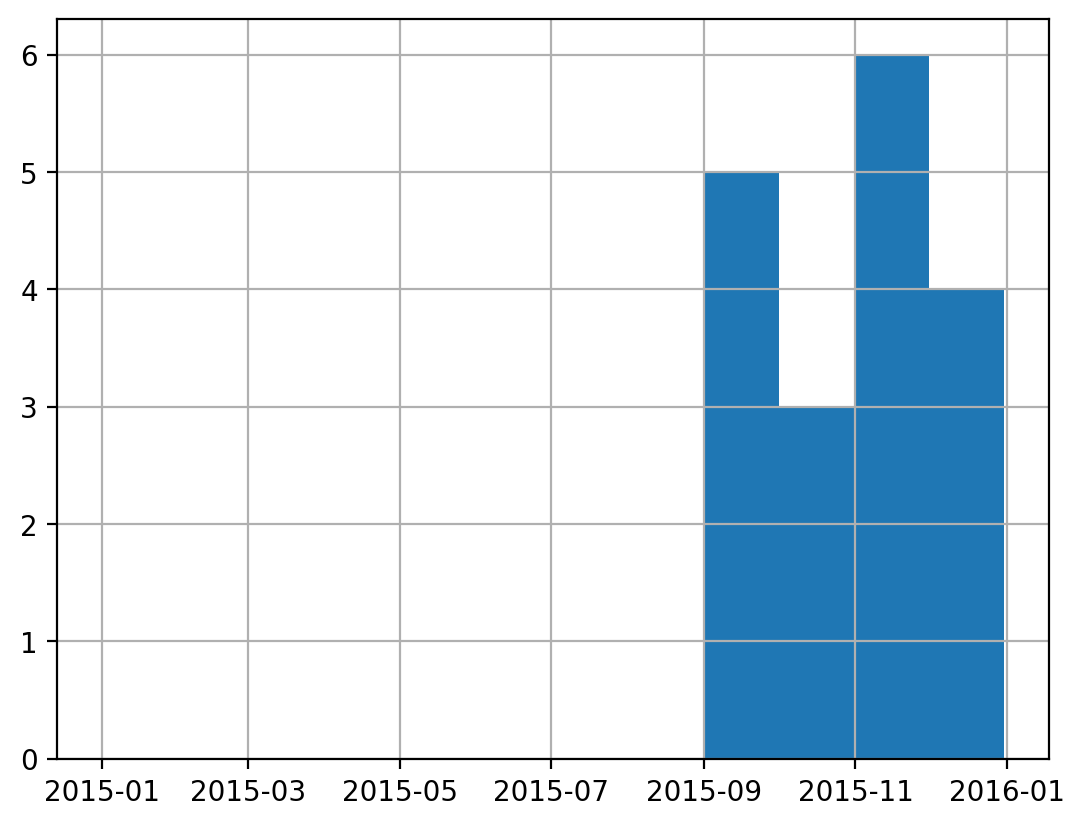

In [ ]:
df.INSPECTION_DATE.hist(range=(pd.to_datetime('2015-01-01'),pd.to_datetime('2015-12-31')), bins=12)

In [ ]:
# Drop the 1900-01-01 inspections. These are all incorrect and we cannot fix them
df['TO_DELETE'] |= (df['INSPECTION_DATE'] == '1900-01-01')

In [ ]:
# After analysis, it seems that we have minimal number of inspections before 2016
df['TO_DELETE'] |=  (df['INSPECTION_DATE'] < '2016-01-01')

In [ ]:
sum(df['TO_DELETE'])

80538

### ACTION

In [ ]:
sum(df.ACTION.isnull())

3874

In [ ]:
df["ACTION"].value_counts()

,count
ACTION,
Violations were cited in the following area(s).,270949
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,10175
No violations were recorded at the time of this inspection.,2280
Establishment re-opened by DOHMH.,1898
Establishment re-closed by DOHMH.,1324


In [ ]:
df["ACTION"] = df["ACTION"].replace(
    to_replace='Violations were cited in the following area(s).',
    value = 'Violations found',
)

In [ ]:
df["ACTION"] = df["ACTION"].replace(
    to_replace='No violations were recorded at the time of this inspection.',
    value = 'No violations'
)

In [ ]:
df["ACTION"] = df["ACTION"].replace(
    to_replace='Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.',
    value = 'Establishment closed'
)

In [ ]:
df["ACTION"] = df["ACTION"].replace(
    to_replace='Establishment re-opened by DOHMH.',
    value = 'Establishment re-opened',
)

In [ ]:
df["ACTION"] = df["ACTION"].replace(
    to_replace='Establishment re-closed by DOHMH.',
    value = 'Establishment re-closed',

)

In [ ]:
df["ACTION"].value_counts()

,count
ACTION,
Violations found,270949
Establishment closed,10175
No violations,2280
Establishment re-opened,1898
Establishment re-closed,1324


In [ ]:
# Drop the Establishment re-opened and re-closed cases
# as the inspection scores for these can be misleading
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-closed')
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-opened')
df['TO_DELETE'] |=  df.ACTION.isnull()

In [ ]:
sum(df['TO_DELETE'])

80538

### SCORE

In [ ]:
df["SCORE"] = pd.to_numeric(df["SCORE"])

In [ ]:
df.SCORE.describe()

,SCORE
count,274244.000000
mean,24.956065
std,18.727938
min,0.000000
25%,12.000000
50%,21.000000
75%,33.000000
max,180.000000


In [ ]:
len(df)

290500

In [ ]:
len( df[ df.SCORE < 0 ] )

0

In [ ]:
df['TO_DELETE'] |= (df.SCORE < 0)

In [ ]:
sum(df['TO_DELETE'])

84640

In [ ]:
# Drop cases reported as "no violations but with positive score"
df['TO_DELETE'] |= ((df.SCORE > 0)  & (df.ACTION == 'No violations'))

# Drop cases with zero score but with violations found
df['TO_DELETE'] |= ((df.SCORE == 0)  & (df.ACTION == 'Violations found'))

In [ ]:
# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='A') & (df.SCORE>13)

df['TO_DELETE'] |=  (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) )

# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='C') & (df.SCORE<28)


In [ ]:
sum(df['TO_DELETE'])

84780

### RECORD_DATE

In [ ]:
df["RECORD_DATE"] = pd.to_datetime(df["RECORD_DATE"], format="%m/%d/%Y")

In [ ]:
# Drop record date field, as it only contains a single value
df = df.drop( 'RECORD_DATE', axis = 'columns')

### GRADE

In [ ]:
df.GRADE.value_counts()

,count
GRADE,
A,96072
B,17897
C,12705
N,7644
Z,6530
P,914


In [ ]:
sum(df.GRADE.isnull())

148738

In [ ]:
df.query(" GRADE == 'N' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
392,50104266,THE CUBAN,Queens,3917,BELL BLVD,11361,5164971911,Latin American,2025-03-05,Violations found,...,Initial Inspection,40.765038466106,-73.771732577426,411,19,112300,4137619,4062410009,QN46,False
726,50170702,LOWLIFE COFFEE,Brooklyn,55,PORTER SBR,NaN,6125169439,Coffee/Tea,2025-07-23,Violations found,...,Pre-permit (Operational) / Initial Inspection,0,0,NaN,NaN,NaN,NaN,3,NaN,True
780,50170702,LOWLIFE COFFEE,Brooklyn,55,PORTER SBR,NaN,6125169439,Coffee/Tea,2025-07-23,Violations found,...,Pre-permit (Operational) / Initial Inspection,0,0,NaN,NaN,NaN,NaN,3,NaN,True
801,50102238,INDIKA HOUSE,Brooklyn,943,BROADWAY,11206,7184843600,Indian,2025-04-11,Violations found,...,Initial Inspection,40.697108505449,-73.935443582616,304,34,038900,3071999,3031600001,BK78,False
1018,50152125,NORIMEN,Manhattan,50,BOWERY,10013,9173876522,American,2025-02-05,Establishment closed,...,Pre-permit (Operational) / Reopening Inspection,40.715755379409,-73.996378255965,103,01,002900,1090946,1002020023,MN27,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290290,50177639,DISTRICT 385,Queens,5736,MYRTLE AVE,11385,6464319059,Latin American,2025-10-10,Violations found,...,Pre-permit (Operational) / Initial Inspection,40.700472091065,-73.902285885346,405,34,055700,4086230,4035730017,QN20,True
290296,50140913,CHASHNI,Brooklyn,1061,CONEY ISLAND AVENUE,11230,3472163066,Coffee/Tea,2025-07-31,Violations found,...,Initial Inspection,40.631395338379,-73.966523364349,314,45,052800,3178873,3066860001,BK42,False
290303,50104266,THE CUBAN,Queens,3917,BELL BLVD,11361,5164971911,Latin American,2025-03-05,Violations found,...,Initial Inspection,40.765038466106,-73.771732577426,411,19,112300,4137619,4062410009,QN46,False
290329,50152128,LUCKY LYNDON,Manhattan,156,EAST 33 STREET,10016,9179913718,Bottled Beverages,2025-03-05,Violations found,...,Pre-permit (Operational) / Initial Inspection,40.7454876763,-73.979663674365,106,04,007200,1018486,1008880047,MN20,True


In [ ]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
95,50098716,EATALY NY LLC (KIOSK),Manhattan,999,BROADWAY,NaN,3124685154,Pizza,2024-06-14,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,0,0,NaN,NaN,NaN,NaN,1,NaN,True
173,50149818,CAFE LAKAY COFFEE SHOP,Brooklyn,3323,AVENUE I,11210,3472625911,Coffee/Tea,2024-09-19,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.629525542446,-73.943928570111,318,45,077600,3206451,3075790001,BK58,True
284,50136259,JI YOU BRAISED FOOD,Queens,4118,MAIN ST,11355,6463396905,Chinese,2023-09-13,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.757730338206,-73.82925152684,407,20,084900,4114237,4050410037,QN22,True
480,50167859,AYAT,Brooklyn,8501,3 AVENUE,11209,7188312585,Mediterranean,2025-05-21,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.624188301335,-74.030749632566,310,43,006200,3153101,3060340007,BK31,True
592,50097045,CHAIRMAN SUN,Queens,4730,VERNON BLVD,11101,2129676088,Chinese,2024-05-29,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.744642891269,-73.953470644374,402,26,000700,4000105,4000300047,QN31,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287414,41271537,EL LIDER RESTAURANT,Bronx,4535,PARK AVENUE,10457,7182202923,Latin American,2022-07-26,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.855662108032,-73.894747612288,206,15,038302,2011173,2030300159,BX40,True
289158,50144282,BENEDICTION RESTAURANT,Queens,21023,JAMAICA AVE,11428,3475511890,Creole,2024-06-04,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.714961666942,-73.750105914726,413,23,049600,4224548,4105430001,QN34,True
289268,50116822,NEW GARDEN,Bronx,1535,WESTCHESTER AVENUE,10472,7189913384,Chinese,2023-07-17,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.828646024589,-73.878439598149,209,18,005400,2025161,2037730003,BX08,True
289527,50138021,EL VIEJO YAYO,Queens,9712,101ST AVE,11416,3475138265,Latin American,2024-12-13,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.684817279847,-73.844009343859,409,32,004001,4189376,4091040005,QN53,True


In [ ]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ").ACTION.value_counts()

,count
ACTION,
Establishment re-opened,914


In [ ]:
# P assigned to 'Reopening Inspection' inspection types
df.query(" GRADE == 'P' ").INSPECTION_TYPE.value_counts()

,count
INSPECTION_TYPE,
Cycle Inspection / Reopening Inspection,731
Pre-permit (Operational) / Reopening Inspection,183


In [ ]:
# df.query(" GRADE == 'Z' ").SCORE.hist(bins=100)

In [ ]:
# TODO: Figure out what Z, and Not Yet Graded means in GRADE
# Until then, we just replace these values with NULL, keeping only the A, B, C grades

#
df.GRADE.value_counts()

,count
GRADE,
A,96072
B,17897
C,12705
N,7644
Z,6530
P,914


In [ ]:
df['TO_DELETE'] |=  (df.GRADE=='Z')
df['TO_DELETE'] |=  (df.GRADE=='P')
df['TO_DELETE'] |=  (df.GRADE=='N') # Not Yet Graded
df['TO_DELETE'] |=  (df.GRADE=='Not Yet Graded')

### GRADE_DATE

In [ ]:
df["GRADE_DATE"] = pd.to_datetime(df["GRADE_DATE"], format="%m/%d/%Y")


In [ ]:
# Grade date and inspection date should be the same.
assert np.abs((df.GRADE_DATE - df.INSPECTION_DATE).dropna()).sum().days == 0

In [ ]:
# Check that is there is a grade date, a grade is also assigned
assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() )  == 0

In [ ]:
# We do not need GRADE DATE if we have INSPECTION DATE
df = df.drop("GRADE_DATE", axis='columns')

### VIOLATION_CODE and VIOLATION_DESCRIPTION

In [ ]:
df.VIOLATION_CODE.isnull().sum()

np.int64(6160)

In [ ]:
# All the cases where violation code is NULL should be either cases that we delete
# or a "No violations" case
check = df[df.VIOLATION_CODE.isnull() & ~df.TO_DELETE & (df.ACTION!='No violations')]

print( len(check) )
assert( len(check) == 0 )


1


AssertionError: 

In [ ]:
df.VIOLATION_DESCRIPTION.isnull().sum()

np.int64(6160)

In [ ]:
# Checks that all VIOLATION_CODE has unique VIOLATION_DESCRIPTION
df[['VIOLATION_CODE','VIOLATION_DESCRIPTION']].drop_duplicates().pivot_table(
    index='VIOLATION_CODE',
    values='VIOLATION_DESCRIPTION',
    aggfunc=pd.Series.nunique
).sort_values('VIOLATION_DESCRIPTION', ascending=False).head(20)

,VIOLATION_DESCRIPTION
VIOLATION_CODE,
06A,4
06C,4
05C,4
02A,3
04D,3
03E,3
03D,3
05D,3
09C,3


In [ ]:
df['TO_DELETE'] |=  (df.VIOLATION_DESCRIPTION == 'Caloric content not posted on menus, menu boards or food tags, in a food service establishment that is 1 of 15 or more outlets operating the same type of business nationally under common ownership or control, or as a franchise or doing business under the same name, for each menu item that is served in portions, the size and content of which are standardized.')

In [ ]:
# In the dataset we have a NULL violation, when there is no violation
# To make this more explicit, we replace NULL with 000
# df.VIOLATION_CODE.fillna('000', inplace=True)

In [ ]:
df.VIOLATION_CODE.isnull().sum()

np.int64(6160)

In [ ]:
## LATITUDE and LONGITUDE

In [ ]:
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'])
df['LATITUDE'] = pd.to_numeric(df['LATITUDE'])

### MISC analysis

In [ ]:
# Find the unique values in each column
#
# df.describe(include = [np.object, 'category']).T['unique']
unique = df.describe(include = 'all').T['unique'].sort_values()

for column in unique.index:
    if unique[column] < 200:
        print(df[column].value_counts())
        print("=====")

TO_DELETE
False    199414
True      91086
Name: count, dtype: int64
=====
CRITICAL_FLAG
Critical          153683
Not Critical      128898
Not Applicable      7919
Name: count, dtype: int64
=====
ACTION
Violations found           270949
Establishment closed        10175
No violations                2280
Establishment re-opened      1898
Establishment re-closed      1324
Name: count, dtype: int64
=====
BORO
Manhattan        107446
Brooklyn          74825
Queens            71426
Bronx             26726
Staten Island     10057
0                    20
Name: count, dtype: int64
=====
GRADE
A    96072
B    17897
C    12705
N     7644
Z     6530
P      914
Name: count, dtype: int64
=====
INSPECTION_TYPE
Initial Inspection                                             152797
Re-inspection                                                   60040
Pre-permit (Operational) / Initial Inspection                   38129
Pre-permit (Operational) / Re-inspection                        10839
Administrative 

In [ ]:
df.dtypes

,0
CAMIS,object
DBA,object
BORO,object
BUILDING,object
STREET,object
ZIPCODE,object
PHONE,object
CUISINE_DESCRIPTION,object
INSPECTION_DATE,datetime64[ns]
ACTION,object


## Deleting Entries

In this section, we use the results of the analysis above, and delete (additional) entries that will not be useful in our analysis. (Note that it is important to document this, as others may want to go back to the original source, if the entries that we leave are not sufficient.)

In [ ]:
len(df)

290500

In [ ]:
assert len(df) == initial_size

In [ ]:
df = df[ df.TO_DELETE == False].copy()

In [ ]:
len(df)

199414

In [ ]:
df[df.VIOLATION_CODE.isnull()].VIOLATION_DESCRIPTION

,VIOLATION_DESCRIPTION
4,NaN
180,NaN
219,NaN
350,NaN
384,NaN
...,...
286558,NaN
286941,NaN
288737,NaN
288740,NaN


## Additional Data Quality Checks

In [ ]:


assert sum(df.INSPECTION_TYPE.isnull()) == 0

assert len(set(df.INSPECTION_TYPE.values)) == 2

df["INSPECTION_TYPE"] =  pd.Categorical(df["INSPECTION_TYPE"], ordered=False)

In [ ]:
# Check that no borough entries are empty
assert sum(df.BORO.isnull()) == 0

df["BORO"] =  pd.Categorical(df["BORO"], ordered=False)

In [ ]:
# Check that no street numbers are empty
assert sum(df.BUILDING.isnull()) == 0

In [ ]:
assert sum(df.STREET.isnull()) == 0

In [ ]:

assert sum(df.CUISINE_DESCRIPTION.isnull()) == 0

df["CUISINE_DESCRIPTION"] =  pd.Categorical(df["CUISINE_DESCRIPTION"], ordered=False)

In [ ]:
# We only keep three different actions
assert len(set(df.ACTION.values)) == 3

# No action is empty
assert sum(df.ACTION.isnull()) == 0

df["ACTION"] =  pd.Categorical(df["ACTION"], ordered=False)

In [ ]:
# The below drops any grade values other than A, B, C, and converts the remaining entries to null
df["GRADE"] =  pd.Categorical(df["GRADE"], categories = ['A', 'B', 'C'], ordered=True)

# https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf
# 0-13 get an A
assert sum( (df.GRADE=='A') & (df.SCORE>13)) == 0

# 14-27 get a B
assert sum( (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) ) ) == 0

# 28- get a C
assert sum( (df.GRADE=='C') & (df.SCORE<28) ) == 0

# TODO: In principle, a NULL grade is only when the score is above 14, and it was an initial inspection

In [ ]:
# Check that is there is a grade date, a grade is also assigned
# assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() ) == 0

In [ ]:
df["VIOLATION_CODE"] =  pd.Categorical(df["VIOLATION_CODE"], ordered=False)
df["CRITICAL_FLAG"] =  pd.Categorical(df["CRITICAL_FLAG"], ordered=False)


In [ ]:
df [ df.VIOLATION_CODE.isnull() ].VIOLATION_DESCRIPTION

,VIOLATION_DESCRIPTION
4,NaN
180,NaN
219,NaN
350,NaN
384,NaN
...,...
286558,NaN
286941,NaN
288737,NaN
288740,NaN


## Normalization

### Violation Codes

In [ ]:
# Recreating the table at https://www1.nyc.gov/assets/doh/downloads/pdf/rii/ri-violation-penalty.pdf

violation_codes = df [ ['VIOLATION_CODE', 'VIOLATION_DESCRIPTION', 'CRITICAL_FLAG'] ].drop_duplicates()
violation_codes = violation_codes.rename( {
    'VIOLATION_DESCRIPTION' : 'DESCRIPTION',
    'CRITICAL_FLAG' : 'CRITICAL'
},  axis = 'columns').sort_values('VIOLATION_CODE').dropna().set_index('VIOLATION_CODE')
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
02B,Hot food item not held at or above 140º F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [ ]:
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
02B,Hot food item not held at or above 140º F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [ ]:
# Drop the description and critical part from the main dataframe
df = df.drop(['VIOLATION_DESCRIPTION' ,  'CRITICAL_FLAG'], axis='columns')

In [ ]:
df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
4,50054294,BOUCHERIE,Manhattan,99,7 AVENUE SOUTH,10014,2128371616,French,2023-05-03,No violations,...,Initial Inspection,40.732935,-74.003175,102,03,007300,1010185,1005910017,MN23,False
49,50011059,PARDON MY FRENCH,Manhattan,103,AVENUE B,10009,2123589683,French,2025-02-25,Violations found,...,Re-inspection,40.724823,-73.981376,103,02,002602,1004672,1003890006,MN28,False
72,50094976,BARDOUGH,Manhattan,350,WEST 46 STREET,10036,9172620543,Pizza,2023-04-28,Violations found,...,Re-inspection,40.760388,-73.989369,104,03,012100,1025023,1010360053,MN15,False
150,50097403,SWEETGREEN,Manhattan,606,1 AVENUE,10016,9175124728,Salads,2024-11-01,Violations found,...,Initial Inspection,40.744073,-73.973280,106,04,008601,1022057,1009660001,MN19,False
162,50043399,KONEKO,Manhattan,26,CLINTON STREET,10002,6463705699,Japanese,2023-12-27,Violations found,...,Initial Inspection,40.720560,-73.984289,103,02,002201,1087346,1003500041,MN28,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290494,41149653,AMOR LOCO,Manhattan,134,WEST 46 STREET,10036,9172615650,Mexican,2025-05-29,Violations found,...,Initial Inspection,40.757840,-73.983360,105,04,011900,1022646,1009980050,MN17,False
290495,40512445,BELLA BLU,Manhattan,967,LEXINGTON AVENUE,10021,2129884624,Italian,2024-12-19,Violations found,...,Re-inspection,40.769283,-73.963020,108,04,012800,1042727,1014050021,MN40,False
290497,50010873,MASALA BOX,Queens,4202,BELL BLVD,11361,7182812699,Indian,2023-01-04,Violations found,...,Initial Inspection,40.762467,-73.770431,411,19,146700,4138216,4062840026,QN46,False
290498,41717500,JOE'S PIZZA,Manhattan,150,EAST 14 STREET,10003,2123889474,Pizza,2024-04-09,Violations found,...,Initial Inspection,40.733656,-73.988082,103,02,004200,1080125,1005590032,MN22,False


### Restaurants

In [ ]:
df.columns.values

array(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESCRIPTION', 'INSPECTION_DATE', 'ACTION',
       'VIOLATION_CODE', 'SCORE', 'GRADE', 'INSPECTION_TYPE', 'LATITUDE',
       'LONGITUDE', 'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BIN', 'BBL', 'NTA', 'TO_DELETE'], dtype=object)

In [ ]:
columns = ['CAMIS', 'DBA', 'BUILDING', 'STREET', 'ZIPCODE', 'BORO', 'PHONE',
           'CUISINE_DESCRIPTION', 'LATITUDE', 'LONGITUDE',
       'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT', 'BIN',
       'BBL', 'NTA']
restaurants =  df [ columns ].drop_duplicates()

In [ ]:
# Check that we have the same attributes for a given CAMIS
# and the we do not have duplicate CAMIS values
assert len(restaurants) == len(set(restaurants.CAMIS.values))

In [ ]:
restaurants.head(5)

,CAMIS,DBA,BUILDING,STREET,ZIPCODE,BORO,PHONE,CUISINE_DESCRIPTION,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA
4,50054294,BOUCHERIE,99,7 AVENUE SOUTH,10014,Manhattan,2128371616,French,40.732935,-74.003175,102,03,007300,1010185,1005910017,MN23
49,50011059,PARDON MY FRENCH,103,AVENUE B,10009,Manhattan,2123589683,French,40.724823,-73.981376,103,02,002602,1004672,1003890006,MN28
72,50094976,BARDOUGH,350,WEST 46 STREET,10036,Manhattan,9172620543,Pizza,40.760388,-73.989369,104,03,012100,1025023,1010360053,MN15
150,50097403,SWEETGREEN,606,1 AVENUE,10016,Manhattan,9175124728,Salads,40.744073,-73.973280,106,04,008601,1022057,1009660001,MN19
162,50043399,KONEKO,26,CLINTON STREET,10002,Manhattan,6463705699,Japanese,40.720560,-73.984289,103,02,002201,1087346,1003500041,MN28


In [ ]:
restaurants.PHONE.value_counts().head(20)

,count
PHONE,
2124656273,43
2126159700,27
9172843260,25
9176186310,24
2125867610,17
6143187413,16
7043285184,16
2122441111,15
2124656302,14


In [ ]:
# __ = restaurants.PHONE.value_counts().head(10).index.values[7]

In [ ]:
# restaurants.PHONE.replace(to_replace=__, value=np.nan, inplace=True)

In [ ]:
# Citi Field concessions
# restaurants.query("PHONE == '7185958100'").head(5)

In [ ]:
# Madison Square Garden concession stands
# restaurants.query("PHONE == '2124656273'").head(5)

In [ ]:
# restaurants.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', alpha=0.2, s=1, figsize=(15,15))

In [ ]:
df = df.drop (columns[1:], axis='columns')

In [ ]:
df

,CAMIS,INSPECTION_DATE,ACTION,VIOLATION_CODE,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
4,50130834,2025-02-12,Violations found,02B,30.0,NaN,Initial Inspection,False
6,50088248,2023-02-16,Violations found,02B,44.0,NaN,Initial Inspection,False
21,41623638,2022-04-25,Violations found,02B,24.0,NaN,Initial Inspection,False
30,50035091,2024-11-20,Violations found,02B,9.0,A,Initial Inspection,False
32,50047362,2023-01-31,Violations found,02B,47.0,NaN,Initial Inspection,False
...,...,...,...,...,...,...,...,...
285020,50001697,2025-03-25,Establishment closed,08A,91.0,NaN,Initial Inspection,False
285022,50089425,2022-07-05,Violations found,08A,13.0,A,Initial Inspection,False
285023,50012109,2023-05-23,Violations found,06C,12.0,A,Initial Inspection,False
285024,50123712,2023-06-07,Violations found,10F,12.0,A,Re-inspection,False


### Inspections

In [ ]:
# Each inspection has multiple violations. We want to keep just the inspections for now
inspection = df.drop('VIOLATION_CODE', axis='columns').drop_duplicates().sort_values(['INSPECTION_DATE', 'CAMIS'])

In [ ]:
inspection

,INSPECTION_ID,CAMIS,INSPECTION_DATE,ACTION,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
0,0,50041177,2016-01-21,Violations found,6.0,A,Initial Inspection,False
1,1,41627984,2016-02-14,Violations found,19.0,NaN,Initial Inspection,False
2,2,41589635,2016-03-11,Violations found,9.0,A,Initial Inspection,False
3,3,41611709,2016-03-26,Violations found,13.0,A,Re-inspection,False
4,4,50003174,2016-04-01,Violations found,29.0,NaN,Initial Inspection,False
...,...,...,...,...,...,...,...,...
60596,60596,50138007,2025-10-18,Violations found,11.0,A,Re-inspection,False
60597,60597,50140292,2025-10-18,Violations found,12.0,A,Re-inspection,False
60598,60598,50144504,2025-10-18,Violations found,12.0,A,Initial Inspection,False
60599,60599,50149760,2025-10-18,Violations found,13.0,A,Initial Inspection,False


In [ ]:
# We create an ID for each inspection here
inspection = inspection.reset_index().drop('index', axis='columns').reset_index().rename({'index': 'INSPECTION_ID'}, axis='columns')

In [ ]:
inspection.ACTION.value_counts()

,count
ACTION,
Violations found,59296
Establishment closed,925
No violations,380


In [ ]:
# Ensure that the inspection table contains
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
pvt [ pvt.INSPECTION_ID > 1 ]

# assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0

,,INSPECTION_ID
INSPECTION_DATE,CAMIS,
2017-11-04,40911114,2


In [ ]:
# df[ (df.CAMIS =='41007054') & (df.INSPECTION_DATE == '2017-03-03')  ].sort_values('VIOLATION_CODE')

In [ ]:
# to_drop = inspection.query(" CAMIS =='50051092' and  INSPECTION_DATE == '2019-09-11' ").index.values[1]
# inspection = inspection.drop(to_drop, axis='index')

In [ ]:
to_drop = inspection.query(" CAMIS =='40911114' and  INSPECTION_DATE == '2017-11-04' ").index.values[1]

inspection = inspection.drop(to_drop, axis='index')

/tmp/ipython-input-3393280888.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  to_drop = inspection.query(" CAMIS =='40911114' and  INSPECTION_DATE == '2017-11-04' ").index.values[1]


In [ ]:
inspection.drop('TO_DELETE', axis='columns', inplace=True)

In [ ]:
# Ensure that the inspection table contains
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0

In [ ]:
inspection.INSPECTION_TYPE.value_counts()

,count
INSPECTION_TYPE,
Initial Inspection,43781
Re-inspection,16819


In [ ]:
inspection_stats = inspection.pivot_table(
    index = 'CAMIS',
    aggfunc = ['min', 'max', 'count'],
    values = 'INSPECTION_DATE'
)

<Axes: xlabel='INSPECTION_DATE'>

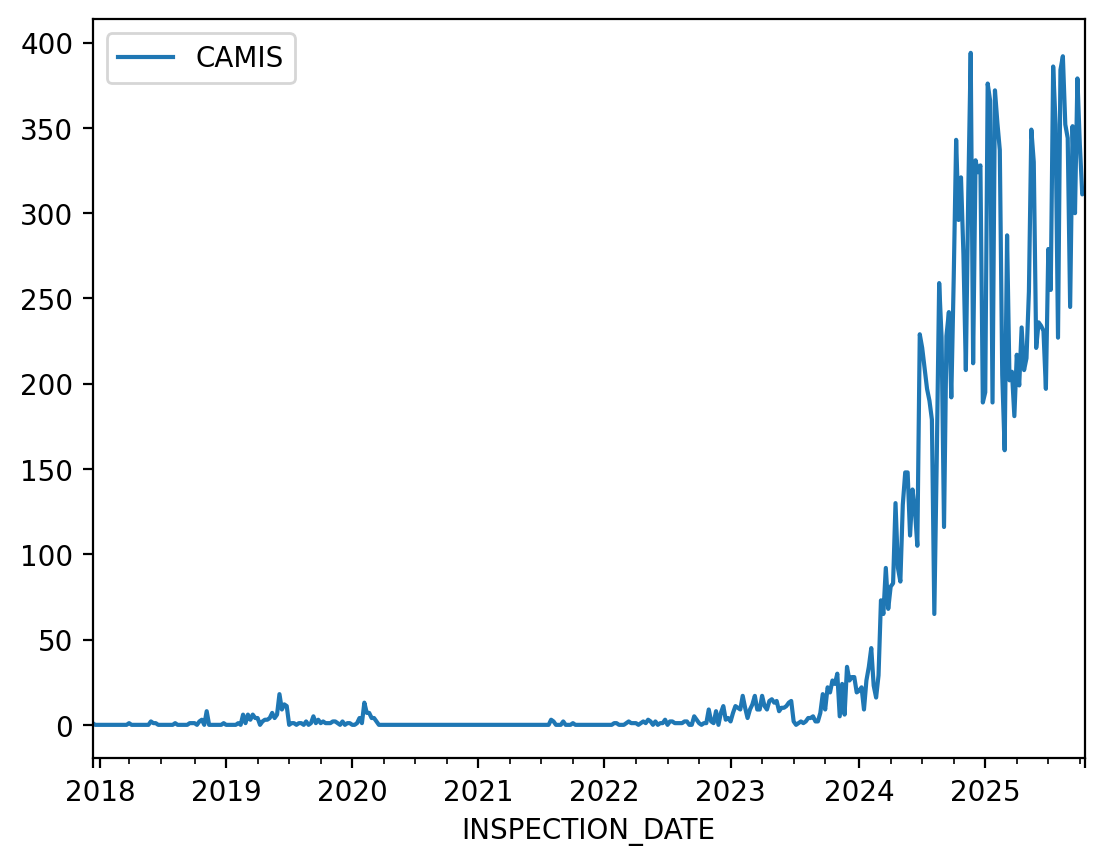

In [ ]:
# Distribution of last inspection across all restaurants
inspection_stats['max'].sort_values('INSPECTION_DATE').reset_index().pivot_table(
    index='INSPECTION_DATE',
    aggfunc='count'
).resample('1W').sum().plot()

In [ ]:
# Longevity
# (inspection_stats['max'] - inspection_stats['min'])['INSPECTION DATE'].sort_values()

<Axes: xlabel='INSPECTION_DATE'>

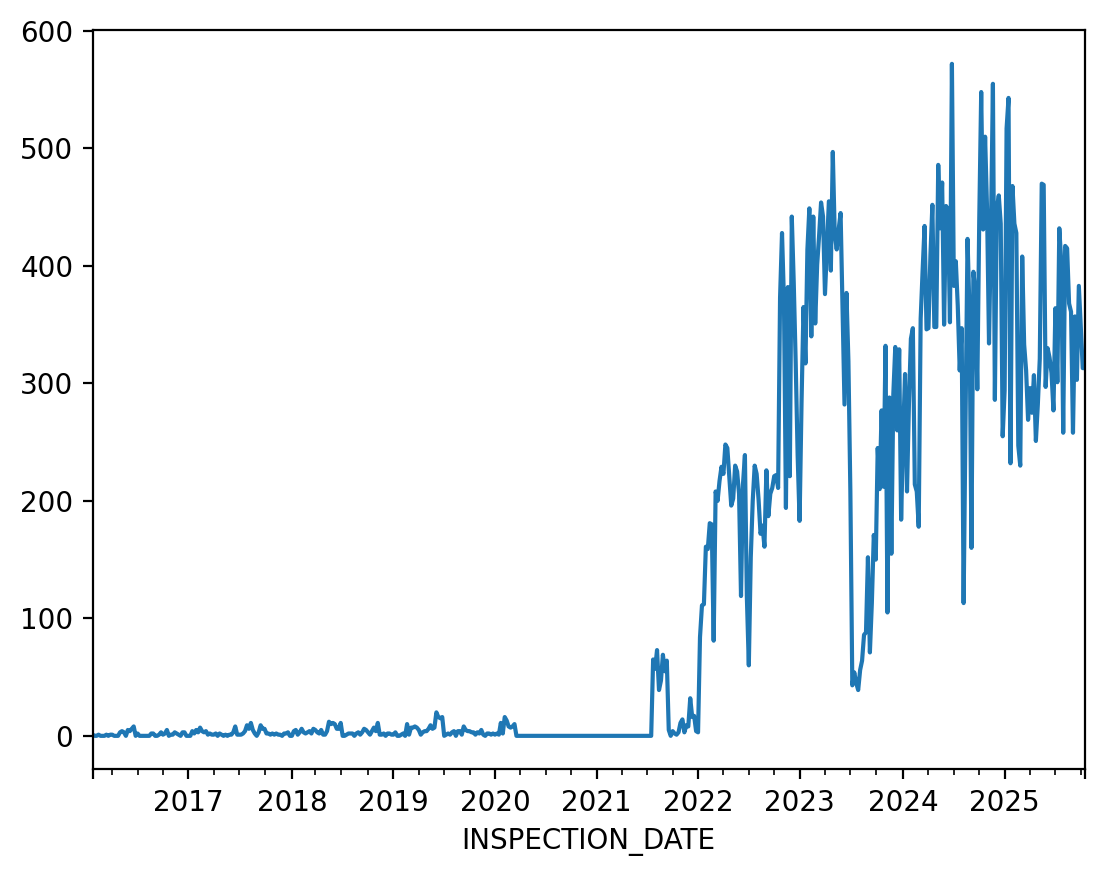

In [ ]:
# Distribution of all inspections
inspection['INSPECTION_DATE'].value_counts().sort_index().resample('1W').sum().plot()

In [ ]:
len(df)

193993

In [ ]:
violations = pd.merge(
    inspection,
    df[ ['CAMIS', 'INSPECTION_DATE', 'VIOLATION_CODE' ] ],
    on= ['CAMIS', 'INSPECTION_DATE'],
    how = 'inner'
)
violations = violations[ ['INSPECTION_ID', 'VIOLATION_CODE'] ].drop_duplicates()
len(violations)

199410

In [ ]:
print(f"Violations: {len(violations)}")
print(f"Inspections: {len(inspection)}")
print(f"Restaurants: {len(restaurants)}")
print(f"Violation Codes: {len(violation_codes)}")

Violations: 199410
Inspections: 60600
Restaurants: 21111
Violation Codes: 146


## Storing in MySQL


In [ ]:
!sudo pip3 install -U -q PyMySQL sqlalchemy sql_magic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.8 MB/s eta 0:00:00


In [ ]:
import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'root',
    password = mysql_pass,
    encoding = 'utf8mb4')

engine = create_engine(conn_string)
con = engine.connect()

In [ ]:
# Query to create a database
db_name = 'doh_restaurants'

sql = f"DROP DATABASE IF EXISTS {db_name}"
with engine.connect() as connection:
  connection.execute(text(sql))

# Create a database
sql = f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8mb4'"
with engine.connect() as connection:
  connection.execute(text(sql))

# And lets switch to the database
sql = f"USE {db_name}"
with engine.connect() as connection:
  connection.execute(text(sql))

In [ ]:
create_table_sql = '''
CREATE TABLE restaurants (
    CAMIS                      char(8),
    DBA varchar(100),
    BUILDING varchar(10),
    STREET varchar(40),
    ZIPCODE char(5),
    BORO ENUM('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island')  ,
    PHONE char(10),
    CUISINE_DESCRIPTION    varchar(30),
LATITUDE                float,
LONGITUDE               float,
COMMUNITY_BOARD          char(3),
COUNCIL_DISTRICT         char(2),
CENSUS_TRACT             char(6),
BIN                      char(7),
BBL                      char(10),
NTA                      char(4),
PRIMARY KEY(CAMIS)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))


create_table_sql = '''
CREATE TABLE inspections (
    INSPECTION_ID               char(8),
    CAMIS                      char(8),
    INSPECTION_DATE    datetime,
    ACTION                   ENUM('Violations found','Establishment closed','No violations'),
    SCORE                     smallint,
    GRADE                    char(1),
    INSPECTION_TYPE          ENUM('Initial Inspection','Re-inspection'),
    FOREIGN KEY(CAMIS) REFERENCES restaurants(CAMIS),
    PRIMARY KEY(INSPECTION_ID)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))

create_table_sql = '''
CREATE TABLE violation_codes (
  VIOLATION_CODE     char(5),
  DESCRIPTION varchar(1000),
  CRITICAL ENUM('Critical', 'Not Applicable', 'Not Critical'),
  PRIMARY KEY(VIOLATION_CODE)

) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))


create_table_sql = '''
CREATE TABLE violations (
  INSPECTION_ID         char(8),
  VIOLATION_CODE     char(5),
  FOREIGN KEY(INSPECTION_ID) REFERENCES inspections(INSPECTION_ID),
  FOREIGN KEY(VIOLATION_CODE) REFERENCES violation_codes(VIOLATION_CODE)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))

In [ ]:
violation_codes.reset_index().VIOLATION_CODE.str.len().max()

5

In [ ]:
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Food not cooked to required minimum temperature.,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
02B,Hot food item not held at or above 140º F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [ ]:
violation_codes = violation_codes.groupby('VIOLATION_CODE').first()

<ipython-input-158-5527dd98b9ff>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  violation_codes = violation_codes.groupby('VIOLATION_CODE').first()


In [ ]:
violation_codes.reset_index().to_sql(
        name = 'violation_codes',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

72

In [ ]:
restaurants["PHONE"].replace(
    to_replace='19292290938',
    value = '9292290938',
    inplace=True
)

<ipython-input-160-7a7a524a034d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  restaurants["PHONE"].replace(


In [ ]:
restaurants.to_sql(
        name = 'restaurants',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

21051

In [ ]:
inspection.to_sql(
        name = 'inspections',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

59476

In [ ]:
violations.to_sql(
        name = 'violations',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

193989

In [ ]:
sql = '''
GRANT SELECT ON doh_restaurants.* TO 'student'@'%'
'''
with engine.connect() as connection:
  connection.execute(text(sql))

In [ ]:


sql = '''
CREATE VIEW restaurant_inspection_latest AS
	WITH latest_inspection AS (
		SELECT CAMIS, MAX(INSPECTION_DATE) AS INSPECTION_DATE FROM inspections
		GROUP BY CAMIS
	)
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO, R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE, I.INSPECTION_DATE, I.INSPECTION_ID, I.INSPECTION_TYPE, V.VIOLATION_CODE, I.SCORE, I.GRADE
		FROM restaurants R
			JOIN latest_inspection L ON R.CAMIS = L.CAMIS
			JOIN inspections I ON I.CAMIS = L.CAMIS AND L.INSPECTION_DATE = I.INSPECTION_DATE
			JOIN violations V ON I.INSPECTION_ID = V.INSPECTION_ID
      '''

with engine.connect() as connection:
  connection.execute(text(sql))

# BigQuery

In [ ]:
# Import bigquery

!pip install -q google-cloud-bigquery pandas-gbq

from google.cloud import bigquery
import pandas_gbq

In [ ]:
# Add this section to write to BigQuery
project_id = "nyu-datasets"
dataset_id = "doh_restaurants"

# Initialize BigQuery client
client = bigquery.Client(project=project_id)

# Create the dataset if it doesn't exist
try:
    client.get_dataset(dataset_id)
    print(f"Dataset {dataset_id} already exists.")
except:
    dataset = bigquery.Dataset(f"{project_id}.{dataset_id}")
    dataset.location = "US" # Or your preferred location
    dataset = client.create_dataset(dataset, exists_ok=True)
    print(f"Dataset {dataset_id} created.")


# Define schema with descriptions for each table
restaurants_schema = [
    {"name": "CAMIS", "type": "STRING", "mode": "NULLABLE", "description": "Restaurant unique identifier"},
    {"name": "DBA", "type": "STRING", "mode": "NULLABLE", "description": "Doing Business As name"},
    {"name": "BUILDING", "type": "STRING", "mode": "NULLABLE", "description": "Building number"},
    {"name": "STREET", "type": "STRING", "mode": "NULLABLE", "description": "Street name"},
    {"name": "ZIPCODE", "type": "STRING", "mode": "NULLABLE", "description": "Zip code"},
    {"name": "BORO", "type": "STRING", "mode": "NULLABLE", "description": "Borough"},
    {"name": "PHONE", "type": "STRING", "mode": "NULLABLE", "description": "Phone number"},
    {"name": "CUISINE_DESCRIPTION", "type": "STRING", "mode": "NULLABLE", "description": "Cuisine type"},
    {"name": "LATITUDE", "type": "FLOAT", "mode": "NULLABLE", "description": "Latitude coordinate"},
    {"name": "LONGITUDE", "type": "FLOAT", "mode": "NULLABLE", "description": "Longitude coordinate"},
    {"name": "COMMUNITY_BOARD", "type": "STRING", "mode": "NULLABLE", "description": "Community board number"},
    {"name": "COUNCIL_DISTRICT", "type": "STRING", "mode": "NULLABLE", "description": "Council district number"},
    {"name": "CENSUS_TRACT", "type": "STRING", "mode": "NULLABLE", "description": "Census tract number"},
    {"name": "BIN", "type": "STRING", "mode": "NULLABLE", "description": "Building Identification Number"},
    {"name": "BBL", "type": "STRING", "mode": "NULLABLE", "description": "Borough Block Lot"},
    {"name": "NTA", "type": "STRING", "mode": "NULLABLE", "description": "Neighborhood Tabulation Area"}
]

inspections_schema = [
    {"name": "INSPECTION_ID", "type": "STRING", "mode": "NULLABLE", "description": "Unique identifier for each inspection"},
    {"name": "CAMIS", "type": "STRING", "mode": "NULLABLE", "description": "Restaurant unique identifier"},
    {"name": "INSPECTION_DATE", "type": "TIMESTAMP", "mode": "NULLABLE", "description": "Date of inspection"},
    {"name": "ACTION", "type": "STRING", "mode": "NULLABLE", "description": "Action taken during inspection"},
    {"name": "SCORE", "type": "INTEGER", "mode": "NULLABLE", "description": "Inspection score"},
    {"name": "GRADE", "type": "STRING", "mode": "NULLABLE", "description": "Inspection grade (A, B, or C)"},
    {"name": "INSPECTION_TYPE", "type": "STRING", "mode": "NULLABLE", "description": "Type of inspection (Initial Inspection or Re-inspection)"}
]

violation_codes_schema = [
    {"name": "VIOLATION_CODE", "type": "STRING", "mode": "NULLABLE", "description": "Code for the violation"},
    {"name": "DESCRIPTION", "type": "STRING", "mode": "NULLABLE", "description": "Description of the violation"},
    {"name": "CRITICAL", "type": "STRING", "mode": "NULLABLE", "description": "Criticality of the violation (Critical, Not Critical, Not Applicable)"}
]

violations_schema = [
    {"name": "INSPECTION_ID", "type": "STRING", "mode": "NULLABLE", "description": "Unique identifier for each inspection"},
    {"name": "VIOLATION_CODE", "type": "STRING", "mode": "NULLABLE", "description": "Code for the violation"}
]


# Write the tables to BigQuery using pandas_gbq
pandas_gbq.to_gbq(restaurants, f"{dataset_id}.restaurants", project_id=project_id, if_exists='replace', table_schema=restaurants_schema)
print("restaurants table written to BigQuery")

pandas_gbq.to_gbq(inspection, f"{dataset_id}.inspections", project_id=project_id, if_exists='replace', table_schema=inspections_schema)
print("inspections table written to BigQuery")

pandas_gbq.to_gbq(violation_codes.reset_index(), f"{dataset_id}.violation_codes", project_id=project_id, if_exists='replace', table_schema=violation_codes_schema)
print("violation_codes table written to BigQuery")

pandas_gbq.to_gbq(violations, f"{dataset_id}.violations", project_id=project_id, if_exists='replace', table_schema=violations_schema)
print("violations table written to BigQuery")


Dataset doh_restaurants already exists.


100%|██████████| 1/1 [00:00<00:00, 10727.12it/s]


restaurants table written to BigQuery


100%|██████████| 1/1 [00:00<00:00, 9341.43it/s]


inspections table written to BigQuery


100%|██████████| 1/1 [00:00<00:00, 11522.81it/s]


violation_codes table written to BigQuery


100%|██████████| 1/1 [00:00<00:00, 12087.33it/s]

violations table written to BigQuery


In [ ]:
# SQL code to run in BigQuery

'''
-- Add description to the restaurants table
ALTER TABLE nyu-datasets.doh_restaurants.restaurants
SET OPTIONS (description = 'Information about NYC restaurants, including their location and cuisine.');

-- Add description to the inspections table
ALTER TABLE nyu-datasets.doh_restaurants.inspections
SET OPTIONS (description = 'Details of health inspections conducted at restaurants, including date, score, and grade.');

-- Add description to the violation_codes table
ALTER TABLE nyu-datasets.doh_restaurants.violation_codes
SET OPTIONS (description = 'Reference table for violation codes and their descriptions.');

-- Add description to the violations table
ALTER TABLE nyu-datasets.doh_restaurants.violations
SET OPTIONS (description = 'Records of specific violations found during inspections, linking inspections to violation codes.');

-- Add Primary Key to the restaurants table
ALTER TABLE `nyu-datasets.doh_restaurants.restaurants`
ADD PRIMARY KEY (CAMIS) NOT ENFORCED;

-- Add Primary Key to the inspections table
ALTER TABLE `nyu-datasets.doh_restaurants.inspections`
ADD PRIMARY KEY (INSPECTION_ID) NOT ENFORCED;

-- Add Foreign Key to the inspections table referencing the restaurants table
ALTER TABLE `nyu-datasets.doh_restaurants.inspections`
ADD CONSTRAINT fk_inspections_restaurants
FOREIGN KEY (CAMIS) REFERENCES `nyu-datasets.doh_restaurants.restaurants`(CAMIS) NOT ENFORCED;

-- Add Primary Key to the violation_codes table
ALTER TABLE nyu-datasets.doh_restaurants.violation_codes
ADD PRIMARY KEY (VIOLATION_CODE) NOT ENFORCED;

-- Add Foreign Key to the violations table referencing the inspections table
ALTER TABLE nyu-datasets.doh_restaurants.violations
ADD CONSTRAINT fk_violations_inspections
FOREIGN KEY (INSPECTION_ID) REFERENCES `nyu-datasets.doh_restaurants.inspections`(INSPECTION_ID) NOT ENFORCED;

-- Add Foreign Key to the violations table referencing the violation_codes table
ALTER TABLE nyu-datasets.doh_restaurants.violations
ADD CONSTRAINT fk_violations_violation_codes
FOREIGN KEY (VIOLATION_CODE) REFERENCES `nyu-datasets.doh_restaurants.violation_codes`(VIOLATION_CODE) NOT ENFORCED;
'''